<a href="https://colab.research.google.com/github/Nithish271/Colab-notebooks/blob/main/Copy_of_3_5_10_SpectogramsMFCCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First load in the function to record your own audio!

### Install required Packages

In [ ]:
!pip install ffmpeg-python &> 0
!pip install tensorflow-io &> 0
!pip install python_speech_features &> 0
print("Packages Installed")

Packages Installed


### Import everything we will need

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import mfcc
from matplotlib import cm
import pickle
import librosa
print("Packages Imported")

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


Packages Imported


### Define the audio importing function.
Adapted from: https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/ and https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=RtMcXr3o6gxN

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

print("Chrome Audio Recorder Defined")

Chrome Audio Recorder Defined


# Load in the Audio Samples
### Record your own audio samples!
After you run each cell wait for the stop button to appear then start recording and then press the button to stop the recording once you have said the word! **If you do not want to record audio then see below for a way to load in the default audio used in the lecture slides.**

In [ ]:
audio_yes_loud, sr_yes_loud = get_audio()
print("DONE")

DONE


In [ ]:
audio_yes_quiet, sr_yes_quiet = get_audio()
print("DONE")

DONE


In [ ]:
audio_no_loud, sr_no_loud = get_audio()
print("DONE")

DONE


In [ ]:
audio_no_quiet, sr_no_quiet = get_audio()
print("DONE")

DONE


In [ ]:
# if you would like to save your files for later, uncomment and run the following
# then you can find your files in the folder icon to the left

audio_files = {
   'audio_yes_loud': audio_yes_loud, 'sr_yes_loud': sr_yes_loud,
   'audio_yes_quiet': audio_yes_quiet, 'sr_yes_quiet': sr_yes_quiet,
   'audio_no_loud': audio_no_loud, 'sr_no_loud': sr_no_loud,
   'audio_no_quiet': audio_no_quiet, 'sr_no_quiet': sr_no_quiet,
 }
with open('audio_files.pkl', 'wb') as fid:
 pickle.dump(audio_files,fid)

### Or load in the default audio samples
By uncommenting and running the below

In [ ]:
!wget --no-check-certificate --content-disposition https://github.com/tinyMLx/colabs/blob/master/audio_files.pkl?raw=true
print("Wait a minute for the file to sync in the Colab and then run the next cell!")

--2022-07-27 13:58:56--  https://github.com/tinyMLx/colabs/blob/master/audio_files.pkl?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tinyMLx/colabs/raw/master/audio_files.pkl [following]
--2022-07-27 13:58:57--  https://github.com/tinyMLx/colabs/raw/master/audio_files.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tinyMLx/colabs/master/audio_files.pkl [following]
--2022-07-27 13:58:57--  https://raw.githubusercontent.com/tinyMLx/colabs/master/audio_files.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [ ]:
 fid = open('audio_files.pkl', 'rb')
 audio_files = pickle.load(fid)
 audio_yes_loud = audio_files['audio_yes_loud']
 sr_yes_loud = audio_files['sr_yes_loud']
 audio_yes_quiet = audio_files['audio_yes_quiet']
 sr_yes_quiet = audio_files['sr_yes_quiet']
 audio_no_loud = audio_files['audio_no_loud']
 sr_no_loud = audio_files['sr_no_loud']
 audio_no_quiet = audio_files['audio_no_quiet']
 sr_no_quiet = audio_files['sr_no_quiet']

You can hear the audio files you loaded by uncommenting and running the below

In [ ]:
Audio(audio_yes_loud, rate=sr_yes_loud)

In [ ]:
Audio(audio_yes_quiet, rate=sr_yes_quiet)

In [ ]:
Audio(audio_no_loud, rate=sr_no_loud)

In [ ]:
Audio(audio_no_quiet, rate=sr_no_quiet)

# Visualize the samples
### First as signals

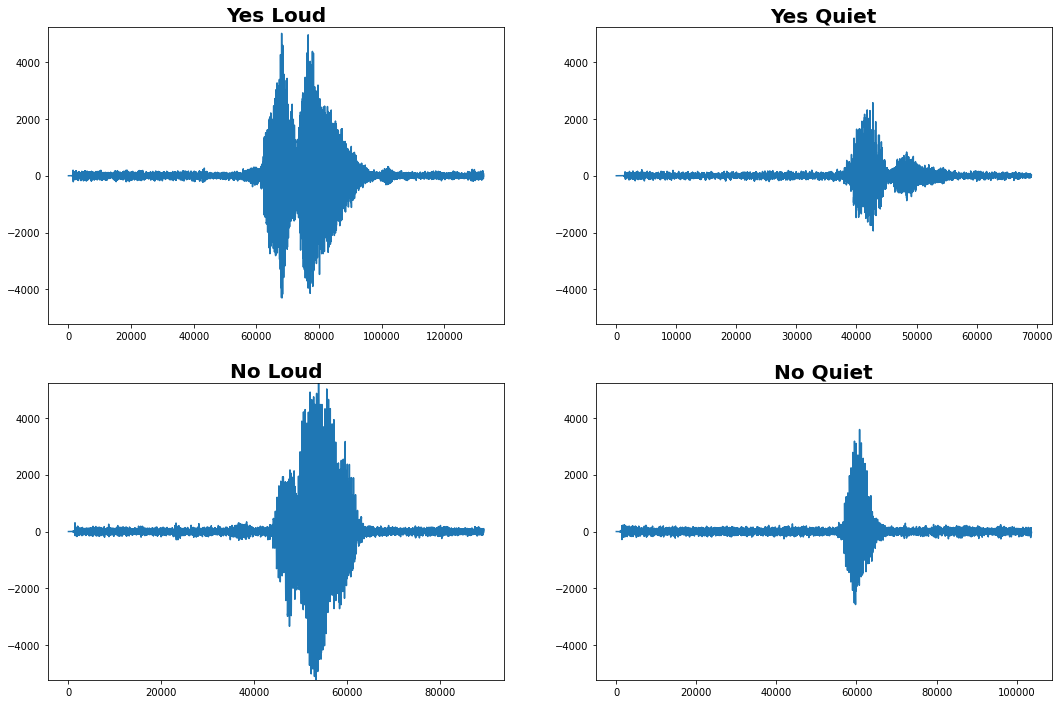

In [ ]:
# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
max_val = max(np.append(np.append(np.append(audio_yes_loud,audio_yes_quiet),audio_no_loud),audio_no_quiet))
ax1.plot(audio_yes_loud)
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(-max_val, max_val)
ax2.plot(audio_yes_quiet)
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(-max_val, max_val)
ax3.plot(audio_no_loud)
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(-max_val, max_val)
ax4.plot(audio_no_quiet)
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(-max_val, max_val)
fig.set_size_inches(18,12)

### Then view the Fourier Transform of the Signal
Viewing the signal in the frequency domain.

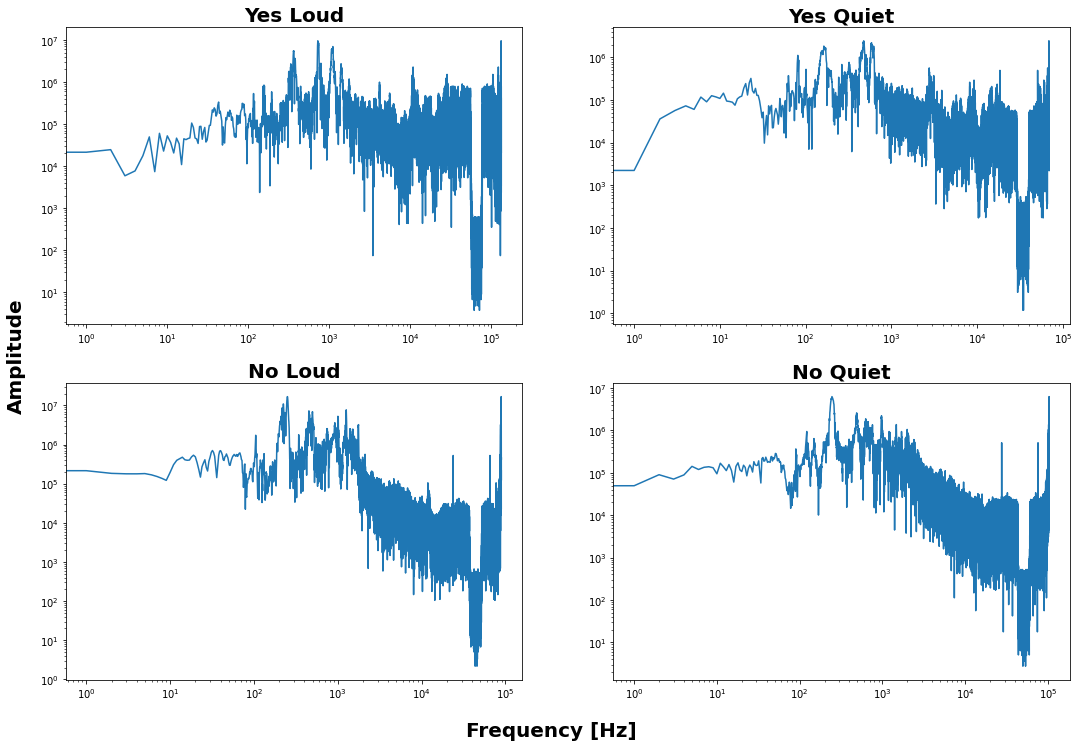

In [ ]:
#Adapted from https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform
# compute the FFT and take the single-sided spectrum only and remove imaginary part
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ft_audio_yes_loud = np.abs(2*np.fft.fft(audio_yes_loud))
ft_audio_yes_quiet = np.abs(2*np.fft.fft(audio_yes_quiet))
ft_audio_no_loud = np.abs(2*np.fft.fft(audio_no_loud))
ft_audio_no_quiet = np.abs(2*np.fft.fft(audio_no_quiet))

# Plot the figure
ax1.plot(ft_audio_yes_loud)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.plot(ft_audio_yes_quiet)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.plot(ft_audio_no_loud)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.plot(ft_audio_no_quiet)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Frequency [Hz]', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Amplitude', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

### Then as spectrograms
Can you see how spectrograms can help machine learning models better differentiate between audio samples?

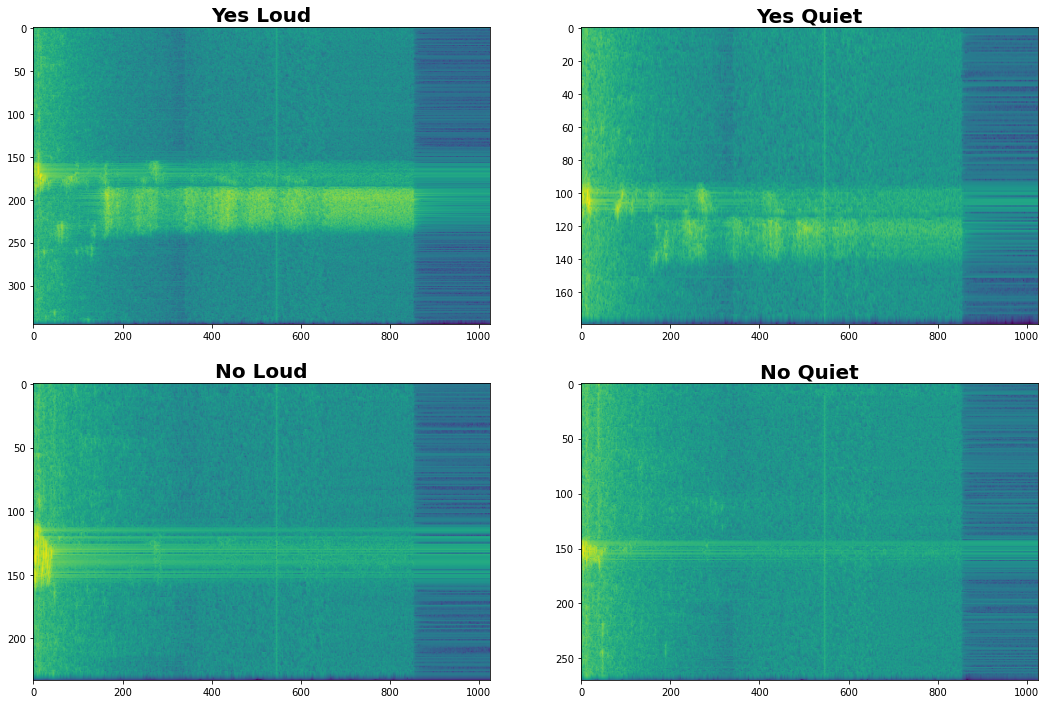

In [ ]:
# Convert to spectrogram and display
# adapted from https://aruno14.medium.com/comparaison-of-audio-representation-in-tensorflow-b6c33a83d77f
spectrogram_yes_loud = tfio.audio.spectrogram(audio_yes_loud/1.0, nfft=2048, window=len(audio_yes_loud), stride=int(sr_yes_loud * 0.008))
spectrogram_yes_quiet = tfio.audio.spectrogram(audio_yes_quiet/1.0, nfft=2048, window=len(audio_yes_quiet), stride=int(sr_yes_quiet * 0.008))
spectrogram_no_loud = tfio.audio.spectrogram(audio_no_loud/1.0, nfft=2048, window=len(audio_no_loud), stride=int(sr_no_loud * 0.008))
spectrogram_no_quiet = tfio.audio.spectrogram(audio_no_quiet/1.0, nfft=2048, window=len(audio_no_quiet), stride=int(sr_no_quiet * 0.008))

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(tf.math.log(spectrogram_yes_loud).numpy(), aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.imshow(tf.math.log(spectrogram_yes_quiet).numpy(), aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.imshow(tf.math.log(spectrogram_no_loud).numpy(), aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.imshow(tf.math.log(spectrogram_no_quiet).numpy(), aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)

### Then as MFCCs
Using the Mel Scale to better associate the features to human hearing!

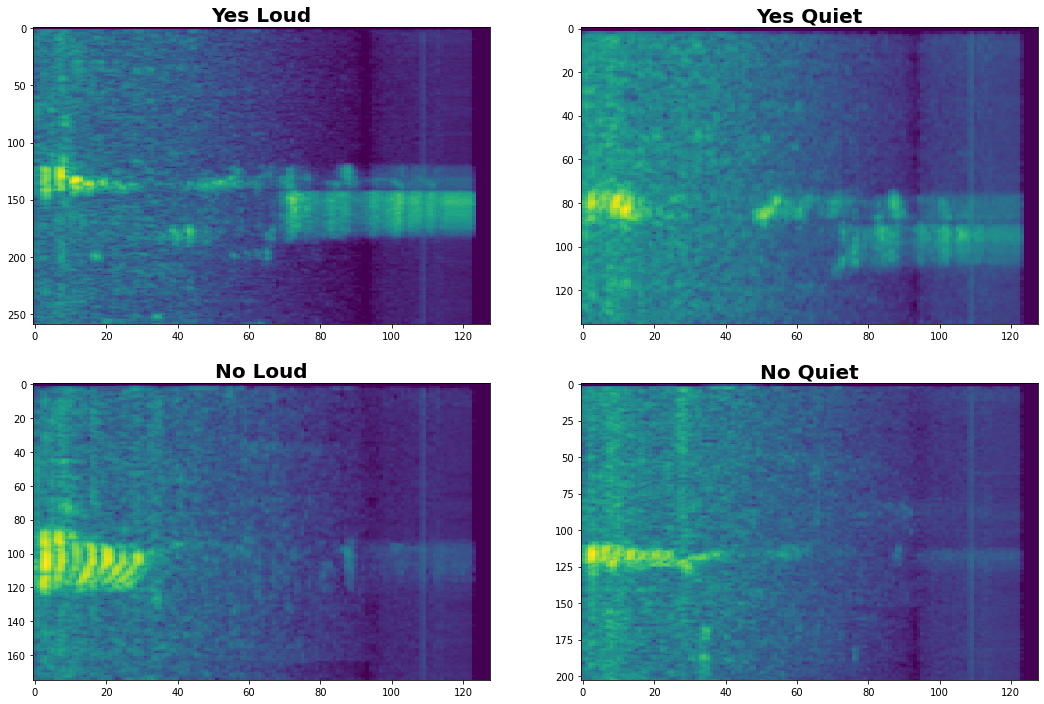

In [ ]:
# Convert to MFCC using the Mel Scale
# adapted from: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
mfcc_yes_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_yes_loud), sr=sr_yes_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_yes_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_yes_quiet), sr=sr_yes_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_no_loud), sr=sr_no_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_no_quiet), sr=sr_no_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(np.swapaxes(mfcc_yes_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.imshow(np.swapaxes(mfcc_yes_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])
ax3.imshow(np.swapaxes(mfcc_no_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])
ax4.imshow(np.swapaxes(mfcc_no_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])
fig.set_size_inches(18,12)